<a href="https://colab.research.google.com/github/orzymandias/emotify-model/blob/master/emotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the necessary packages

In [0]:
print("begining import...")
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras


# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.model_selection import train_test_split


print("[+] Using Keras version",keras.__version__)


begining import...
[+] Using Keras version 2.3.0-tf




## Importing Data and Data Exploration
  



In [0]:
  CSV_DATA_URL = "https://raw.githubusercontent.com/orzymandias/emotify-model/master/data/data.csv"
  df = pd.read_csv(CSV_DATA_URL, names=["content", "sentiment"])
  df.head()

,content,sentiment
0,I hope all the Romo haters see how much we nee...,anger
1,When your boyfriend promised he'd take you for...,anger
2,The whole fucking team did their part EXCEPT K...,anger
3,@hannah_wootton @JessicaTidball @millyharrison...,anger
4,@CANDYCORNTIME and I never rap battled. #pissed,anger


#### Key Metrics of combined dataset
  * Number of samples: 48145
  * Number of classes: 4 (After merger)
  * Number of samples per class: (Shown under sentiment count)




In [0]:
df = df.drop_duplicates(subset=['content'], keep='first')  # remove duplicate data
df = df[(df.sentiment == "sadness") # filtering emotions of interest
    | (df.sentiment == "anger") 
    | (df.sentiment == "joy")
    | (df.sentiment == "happiness")
    | (df.sentiment == "fun") 
    | (df.sentiment == "fearful")
    | (df.sentiment == "fear") 
    | (df.sentiment == "hate")
    | (df.sentiment == "hate")
    | (df.sentiment == "empty")]
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(48266, 2)


,content,sentiment
0,I hope all the Romo haters see how much we nee...,anger
1,When your boyfriend promised he'd take you for...,anger
2,The whole fucking team did their part EXCEPT K...,anger
3,@hannah_wootton @JessicaTidball @millyharrison...,anger
4,@CANDYCORNTIME and I never rap battled. #pissed,anger


#### Data Imbalance
We discover that we have an imbalanced dataset - there are overlapping categories and disproportional categories.




sadness      11014
anger         8958
fearful       8559
joy           8135
happiness     5184
fear          2498
fun           1775
hate          1322
empty          821
Name: sentiment, dtype: int64


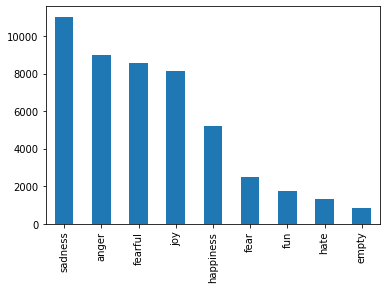

In [0]:
print(df.sentiment.value_counts())
df['sentiment'].value_counts().plot(kind='bar')


#### Actions to be taken:

*   Merge the happiness, joy and fun
*   Merge the anger and hate classes
*   Merge the sadness and empty classes
*   Merge the worry and fear classes
* Down-sampling the majority class ensure balance

In [0]:

df.dropna(inplace = True)
df["sentiment"] = df["sentiment"].replace({'empty': 'sadness', "hate": "anger","fun": "happiness",  "joy": "happiness", "fearful": "fear"})
print(df.sentiment.value_counts())


happiness    15094
sadness      11835
fear         11057
anger        10279
Name: sentiment, dtype: int64


#### Downsampling to achieve balance 

* Achieving balance is critical to ensure tha tt the model is not overtrained and overfits for a particular feature


In [0]:
happiness, worry, sadness, anger = df.sentiment.value_counts()
df_fear = df[df["sentiment"] == "fear"].sample(10000)
df_happiness = df[df["sentiment"] == "happiness"].sample(10000)
df_sadness = df[df["sentiment"] == "sadness"].sample(10000)
df_anger = df[df["sentiment"] == "anger"].sample(10000)
df = pd.concat([df_fear, df_happiness, df_sadness, df_anger], axis=0)

df.reset_index(drop=True, inplace=True)
print(df.sentiment.value_counts())


happiness    10000
sadness      10000
anger        10000
fear         10000
Name: sentiment, dtype: int64


### Key Metrics of usable dataset
  * Number of samples: 40,000
  * Number of classes: 4
  * Number of samples per class: 4000/5000
  * Median words per sample: 14
  * Samples/words-per-sample ratio: 1357 (borderline 1500)

In [0]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)
print("\n\nMedian number of words per sample: ", get_num_words_per_sample(df['content']))




Median number of words per sample:  14.0


## Preprocessing and Data Cleaning






#### Encoding Emotions to Ids

* 0 - anger  
* 1 - fear
* 2 - happiness
* 3 - sadness



In [0]:
df['sentiment'] = pd.Categorical(df['sentiment'])
df['sentiment'] = df.sentiment.cat.codes
df.head(17888)

,content,sentiment
0,I Broke Up With Cause I Finally Realized It Wa...,1
1,Definately in need of a stiff drink after toda...,1
2,If you want to see some jacked dudez go to the...,1
3,Omg some little girl in #WindsorCastle shoutin...,1
4,#storm is coming to the south.. #terrified,1
...,...,...
17883,@OliviaPinupArt A big welcome to Twitterlandz ...,2
17884,I just got home. i bought twiggies and a toot...,2
17885,Spending my afternoon brushing the hair of a t...,2
17886,All town centres and retail parks will be busy...,2


#### Clean tweets



In [0]:
!pip install tweet-preprocessor
import preprocessor as p
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords

print(df.content.head(10))
def clean_sentence(sentence):
    # removing handles and links
    sentence = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split())

    # removing stopwords
    # stop_words = list(stopwords.words('english'))   
    # sentence = " ".join([word.lower() for word in sentence.split() if word not in (stop_words)])   
    sentence = " ".join([word.lower() for word in sentence.split()])   
    
    p.set_options(p.OPT.URL, p.OPT.EMOJI)
    return p.clean(sentence)


df['content'] = df['content'].map(lambda x: clean_sentence(x))

print("-------------------- After cleaning--------------------")
print(df.content.head(10))
    

0    I Broke Up With Cause I Finally Realized It Wa...
1    Definately in need of a stiff drink after toda...
2    If you want to see some jacked dudez go to the...
3    Omg some little girl in #WindsorCastle shoutin...
4           #storm is coming to the south.. #terrified
5    Best that thing about horror movies is the kit...
6    This is where I paused #labyrinth just now. #h...
7    Group to Help with Stress and Worries Services...
8    The closer moving away from home gets the more...
9    The @OfficialPWG pictures will be up tomorrow....
Name: content, dtype: object
-------------------- After cleaning--------------------
0    i broke up with cause i finally realized it wa...
1    definately in need of a stiff drink after toda...
2    if you want to see some jacked dudez go to the...
3    omg some little girl in windsorcastle shouting...
4               storm is coming to the south terrified
5    best that thing about horror movies is the kit...
6    this is where i paused labyrin

#### Spliting training and test set




In [0]:
sentiment = df.pop("sentiment")
content = df

x_train, y_train, x_test, y_test = train_test_split(content, sentiment, test_size=0.20, shuffle=True, random_state=42)
print(" Training: size", x_train.shape[0])
print(" Validation size:",y_train.shape[0])
training_data, validation_data, training_label, validation_label = np.array(x_train.content), np.array(y_train.content), np.array(x_test), np.array(y_test)



 Training: size 32000
 Validation size: 8000


#### Model Parameters

In [0]:
TOP_K = 10000
MAX_SEQUENCE_LENGTH = 28
num_classes = 4


#### Tokenization and Vectorization

* Tokenizes the texts into words
* Creates a vocabulary using the top 20,000 tokens
* Converts the tokens into sequence vectors
* Pads the sequences to a fixed sequence length


In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
def sequence_vectorize(train_texts, val_texts):
   
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)
    print("tokenizer", train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)
    print("training_data_vectorized", x_train)
    print("validation_data_vectorized", x_val)

    # Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
    x_val = sequence.pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH)
    return x_train, x_val, tokenizer.word_index

training_data_vectorized, validation_data_vectorized, word_index = sequence_vectorize(training_data,validation_data)
print(training_data_vectorized[0].shape)

tokenizer ['sale sale sale quot gt'
 'larkin studying for history exam all day wasteofagoodnapday nooneneedshistorytobeatrophywife'
 'brilliant weekend brilliant i say in work now and actually working' ...
 'u know when u expectin somethin and it doesnt happen and that person also doesnt make an effort to reach out to tell u whats what pissed'
 'everytime i watch the movie it s never because it s an amazing movie just to see fine ass mark wahlberg'
 'feeling so great']
training_data_vectorized [[1511, 1511, 1511, 50, 423], [667, 12, 721, 656, 32, 40], [2568, 195, 2568, 1, 180, 9, 64, 36, 5, 310, 237], [1327, 389, 60, 170, 485, 10, 17, 20, 1512], [1, 101, 37, 7, 6, 6268, 39, 6, 226, 566, 9804, 5, 1, 101, 262, 5, 914, 1, 2428, 46, 3, 49, 36, 163, 153, 252, 15, 193, 3, 255, 25, 19, 249, 7, 521, 2569, 42, 889, 1040, 262], [19, 497, 13, 4, 18, 2132, 54], [1, 926, 13, 21, 109, 9805, 369, 4, 348, 157, 1, 183, 13, 246, 88, 14], [1651, 2133, 122, 287, 90, 28, 298, 35, 41, 848, 30, 133, 75, 140,

In [0]:
validation_data_vectorized.shape

(8000, 28)

####Model 1: sepCNN
  * Tensorflow documentation

In [0]:
# from tensorflow.python.keras import models
# from tensorflow.python.keras import initializers
# from tensorflow.python.keras import regularizers

# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras.layers import Dropout
# from tensorflow.python.keras.layers import Embedding
# from tensorflow.python.keras.layers import SeparableConv1D
# from tensorflow.python.keras.layers import MaxPooling1D
# from tensorflow.python.keras.layers import GlobalAveragePooling1D

# def sepcnn_model(blocks,
#                  filters,
#                  kernel_size,
#                  embedding_dim,
#                  dropout_rate,
#                  pool_size,
#                  input_shape,
#                  num_classes,
#                  num_features):

#     op_units, op_activation = num_classes, "softmax"
#     model = models.Sequential()
#     model.add(Embedding(input_dim=TOP_K + 1,
#                           output_dim=embedding_dim,
#                           input_length=input_shape))

#     for _ in range(blocks-1):
#         model.add(Dropout(rate=dropout_rate))
#         model.add(SeparableConv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   bias_initializer='random_uniform',
#                                   depthwise_initializer='random_uniform',
#                                   padding='same'))
#         model.add(SeparableConv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   bias_initializer='random_uniform',
#                                   depthwise_initializer='random_uniform',
#                                   padding='same'))
#         model.add(MaxPooling1D(pool_size=pool_size))

#     model.add(SeparableConv1D(filters=filters * 2,
#                               kernel_size=kernel_size,
#                               activation='relu',
#                               bias_initializer='random_uniform',
#                               depthwise_initializer='random_uniform',
#                               padding='same'))
#     model.add(SeparableConv1D(filters=filters * 2,
#                               kernel_size=kernel_size,
#                               activation='relu',
#                               bias_initializer='random_uniform',
#                               depthwise_initializer='random_uniform',
#                               padding='same'))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dropout(rate=dropout_rate))
#     model.add(Dense(op_units, activation=op_activation))
#     model.summary()
#     return model

# model = sepcnn_model(blocks=2,
#                      filters=64,
#                      kernel_size=3,  # Kenel size: recommended 3 or 5
#                      dropout_rate=0.3, # Dropout rate, reccomended range: 0.2–0.5.,
#                      pool_size=3, 
#                      num_classes=4,
#                      input_shape= MAX_SEQUENCE_LENGTH,
#                      embedding_dim=200, # Embedding Dimension: size of each word vector. Recommended values: 50–300
#                      num_features=TOP_K)

#### Model 2: CNN

* loss: 0.8516 - acc: 0.6304 - val_loss: 0.8652 - val_acc: 0.6229
* loss: 0.8539 - acc: 0.6303 - val_loss: 0.8567 - val_acc: 0.6270

In [0]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from keras import models
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer

def cnn_Model(dropout_rate, num_classes):
    model = models.Sequential()
    model.add(Embedding(TOP_K + 1,
                        50,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(64,
                     4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(num_classes, activation="sigmoid"))
    # model.add(Dense(num_classes, activation="softmax"))
    model.summary()

    return model



model = cnn_Model(num_classes=num_classes, dropout_rate=0.2)


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 28, 50)            500050    
_________________________________________________________________
dropout_108 (Dropout)        (None, 28, 50)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 25, 64)            12864     
_________________________________________________________________
global_max_pooling1d_34 (Glo (None, 64)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_109 (Dropout)        (None, 256)               0         
_________________________________________________________________
activation_34 (Activation)   (None, 256)             

####Model 3: RNN LSTM Model
* Performance
  * loss: 0.8149 - acc: 0.6585 - val_loss: 0.8769 - val_acc: 0.6173
  * loss: 0.8156 - acc: 0.6591 - val_loss: 0.8729 - val_acc: 0.6227



In [0]:
from keras import models
from keras.layers import Embedding, Dense, LSTM, Dropout, SpatialDropout1D

def lstm_RNN(num_classes, dropout_rate):
    model = models.Sequential()
    model.add(Embedding(TOP_K,
                        200,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=dropout_rate, recurrent_dropout=0.3))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation="softmax"))
    model.summary()
    return model

model = lstm_RNN(4, 0.2)

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 28, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 28, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dropout_111 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 4)                 204       
Total params: 2,050,404
Trainable params: 2,050,404
Non-trainable params: 0
_________________________________________________________________



#### Model 4: Pretrained Embedded Model with MLP
* Performance
  * loss: 0.9027 - acc: 0.6317 - val_loss: 1.0744 - val_acc: 0.5468





* Import TFhub

In [0]:
!pip install -q tensorflow-hub



In [0]:
from keras import models
import tensorflow_hub as hub
import tensorflow_datasets as tfds

embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

def transferEmbedding(layers, units, dropout_rate, num_classes):
  model = tf.keras.Sequential()
  model.add(hub_layer)

  for _ in range(layers-1):
        model.add(tf.keras.layers.Dense(units=units, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
        # model.add(tf.keras.layers.Dense(num_classes, activation="sigmoid"))

  model.summary()
  return model

model = transferEmbedding(3, 32, 0.3, 2)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_40 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 66        
_________________________________________________________________
dense_42 (Dense)             (None, 32)                96        
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)               

#### Model 5: RNN LSTM2
  * 0.7894 - acc: 0.6669 - val_loss: 0.8719 - val_acc: 0.6285

In [0]:
def RNN_LSTM2(dropout_rate):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(TOP_K, 200, input_length=training_data_vectorized.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(dropout_rate))
  model.add(tf.keras.layers.LSTM(50, dropout=dropout_rate, recurrent_dropout=0.2))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  model.summary()
  return model

RNN_LSTM2(0.2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 28, 200)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 204       
Total params: 2,050,404
Trainable params: 2,050,404
Non-trainable params: 0
_________________________________________________________________


#### Hyperparameters

In [0]:
learning_rate = 1e-4
batch_size = 64
epochs =20
dropout_rate=0.2
kernel_size = 3


In [0]:
'''
  To save model to your drive
  Set checkpoint_path accordingly drive/My Drive/xxx
'''
from google.colab import drive
import os
drive.mount('/content/drive')
checkpoint_path = "/content/model/"
checkpoint_dir = os.path.dirname(checkpoint_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Training

* https://ruder.io/optimizing-gradient-descent/

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

# Initlize Model
model = cnn_Model(num_classes=num_classes, dropout_rate=dropout_rate)
# model = lstm_RNN(num_classes=num_classes, dropout_rate=dropout_rate)
# model = transferEmbedding(layers=2, units=64, dropout_rate=dropout_rate, num_classes=num_classes)
# model = RNN_LSTM2(dropout_rate=dropout_rate)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = checkpoint_path + 'my_model.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]
        

# model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer="adadelta", loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit Model
# remember to switch training data depending on model
history = model.fit(
            training_data_vectorized,
            training_label,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(validation_data_vectorized, validation_label),
            verbose=1,  # Logs once per epoch.
            batch_size=batch_size)


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 28, 50)            500050    
_________________________________________________________________
dropout_112 (Dropout)        (None, 28, 50)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 25, 64)            12864     
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_113 (Dropout)        (None, 256)               0         
_________________________________________________________________
activation_35 (Activation)   (None, 256)             

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 8s 238us/step - loss: 0.9503 - acc: 0.5471 - val_loss: 0.6822 - val_acc: 0.7094

Epoch 00001: val_loss improved from inf to 0.68216, saving model to /content/model/my_model.h5
Epoch 2/20
32000/32000 [==============================] - 7s 231us/step - loss: 0.6261 - acc: 0.7418 - val_loss: 0.6229 - val_acc: 0.7464

Epoch 00002: val_loss improved from 0.68216 to 0.62293, saving model to /content/model/my_model.h5
Epoch 3/20
32000/32000 [==============================] - 8s 235us/step - loss: 0.5609 - acc: 0.7784 - val_loss: 0.5996 - val_acc: 0.7632

Epoch 00003: val_loss improved from 0.62293 to 0.59961, saving model to /content/model/my_model.h5
Epoch 4/20
32000/32000 [==============================] - 7s 233us/step - loss: 0.5169 - acc: 0.7985 - val_loss: 0.6005 - val_acc: 0.7684

Epoch 00004: val_loss did not improve from 0.59961
Epoch 5/20
32000/32000 [===========================

Plot loss graph

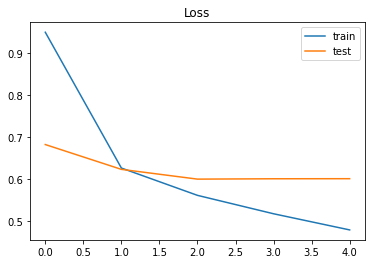

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

### Model Evaluation

In [0]:
loss,acc = model.evaluate(validation_data_vectorized,  validation_label, verbose=2)
print("model accuracy: {:5.2f}% \nmodel loss {:5.2f}".format(100*acc, loss))


model accuracy: 76.97% 
model loss  0.60


              precision    recall  f1-score   support

       anger       0.88      0.75      0.81      2000
        fear       0.95      0.85      0.90      2047
   happiness       0.65      0.78      0.71      1967
     sadness       0.65      0.69      0.67      1986

    accuracy                           0.77      8000
   macro avg       0.78      0.77      0.77      8000
weighted avg       0.79      0.77      0.77      8000



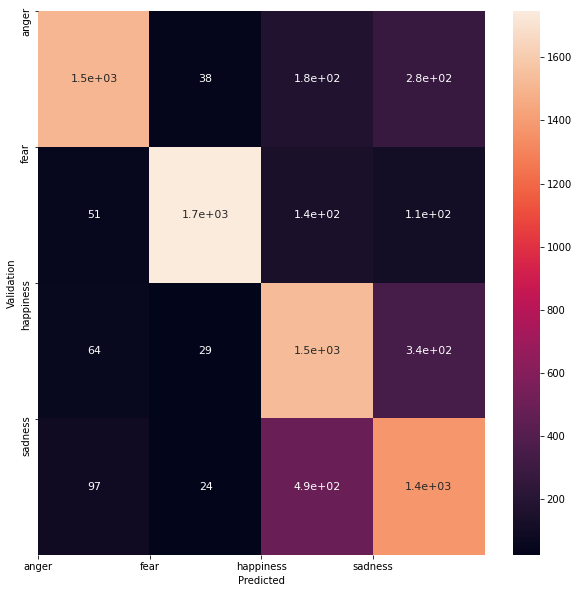

In [0]:
 from sklearn.metrics import classification_report, confusion_matrix
 import seaborn as sn


#  labels = ["anger", "happiness", "sadness","worry"]
 labels = ["anger", "fear", "happiness", "sadness"]

 predictions = model.predict(validation_data_vectorized)
 predictions = np.argmax(predictions,axis=1)

print(classification_report(validation_label, predictions, target_names=labels))


matrix = confusion_matrix(validation_label, predictions)
plt.figure(figsize=(10,10))
sn.heatmap(matrix, annot=True, annot_kws={"size": 11}) # font size
plt.xlabel('Predicted')
plt.ylabel('Validation')
plt.xticks(np.arange(4), labels)
plt.yticks(np.arange(4), labels)

plt.show()

In [0]:
from tensorflow.python.keras.preprocessing import text

def tokenize_and_pad(input):
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(training_data)
    tokenized = tokenizer.texts_to_sequences(input)
    padded = sequence.pad_sequences(tokenized, maxlen=MAX_SEQUENCE_LENGTH)
    return padded

def predict_emo(input):
    encoded = tokenize_and_pad([input])
    return model.predict(encoded)

'''
  non transfer learning models
  labels = ["anger", "fear", "happiness", "sadness"]
'''
emotion = np.argmax(predict_emo("he's so scary"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("I am over the moon"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("dont hurt me"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("I hate you"))
print(f"Predicted emotion: {labels[emotion]}")

# transfer learning model
# model.predict(["I am in pain"])


Predicted emotion: fear
Predicted emotion: happiness
Predicted emotion: sadness
Predicted emotion: anger


####Save Model


In [0]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras ‘/content/model/my_model.h5’ ‘/content/model’


Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 671, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 675, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 593, in convert
    weight_shard_size_bytes=weight_shard_size_bytes)
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 75, in dispatch_keras_h5_to_tfjs_layers_model_conversion
    raise ValueError('Nonexistent path to HDF5 file: %s' % h5_path)
ValueError: Nonexistent path to HDF5 file: ‘/content/model/my_model.h5’
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/loca